In [1]:
from metalib.utils import load_multiple_hist_data, load_hist_data

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
assets = ['EURUSD']

In [87]:
ohlc = pd.concat([load_hist_data(assets[0], 2020),
                 load_hist_data(assets[0], 2021),
                 load_hist_data(assets[0], 2022), 
                 load_hist_data(assets[0], 2023)]
                ).resample('1H').agg({'open': 'first',
                         'high': 'max',
                         'low': 'min',
                         'close': 'last',
                    }).dropna()

# ohlc = pd.concat([df for k,df in ohlc.items()], axis=1)
ohlc.index = pd.DatetimeIndex(ohlc.index, tz='UTC')
ohlc = ohlc.tz_convert(tz='US/Eastern')

C:\Users\Trismegist\anaconda3\envs\adonys\lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
C:\Users\Trismegist\anaconda3\envs\adonys\lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
C:\Users\Trismegist\anaconda3\envs\adonys\lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the

In [88]:
ohlc_daily = ohlc.resample('1D').agg({'open': 'first', 
                         'high': 'max', 
                         'low': 'min', 
                         'close': 'last',
                    })

In [107]:
# Function to find the open of the second Monday of the month
def get_second_monday_open_ffill(ohlc_df, index_to_refill):
    """
    Returns a Pandas Series containing the 'open' prices of the second Monday of each month,
    forward-filled to match the original DataFrame's index.

    Parameters:
        ohlc_df (pd.DataFrame): Daily OHLC DataFrame with a datetime index and an 'open' column.

    Returns:
        pd.Series: Series with the same index as ohlc_df, containing forward-filled second Monday 'open' prices.
    """
    # Ensure the index is a datetime index
    if not isinstance(ohlc_df.index, pd.DatetimeIndex):
        ohlc_df.index = pd.to_datetime(ohlc_df.index)
    
    # Extract Mondays
    mondays = ohlc_df[ohlc_df.index.weekday == 0]  # 0 represents Monday

    # Group by year and month to find the second Monday
    second_mondays = mondays.groupby([mondays.index.year, mondays.index.month]).nth(1)  # nth(1) is the second Monday

    # Create a Series for second Monday opens
    second_monday_series = second_mondays['open']

    # Reindex to match the original DataFrame and forward-fill missing values
    second_monday_ffill = second_monday_series.reindex(index_to_refill, method='ffill')

    return second_monday_ffill

def get_first_monday_of_april_open_ffill(ohlc_df, index_to_refill):
    """
    Returns a Pandas Series containing the 'open' prices of the first Monday
    in April for each year, forward-filled to match the given index.

    Parameters:
        ohlc_df (pd.DataFrame): A daily (or intraday) DataFrame with a DateTime index and an 'open' column.
        index_to_refill (pd.Index): Index to which the returned Series will be reindexed and then forward-filled.

    Returns:
        pd.Series: A Series (same index as index_to_refill) with forward-filled
                   first Monday of April 'open' prices.
    """
    # Ensure the index is a datetime index
    if not isinstance(ohlc_df.index, pd.DatetimeIndex):
        ohlc_df.index = pd.to_datetime(ohlc_df.index)
    
    # Filter for Mondays in April
    april_mondays = ohlc_df[
        (ohlc_df.index.month == 4) & (ohlc_df.index.weekday == 0)
    ]
    
    # Group by year to find the first Monday in April for each year
    first_mondays_april = april_mondays.groupby(april_mondays.index.year).nth(0)
    
    # Extract the 'open' column
    first_april_open = first_mondays_april['open']
    
    # Reindex to match the target index, then forward-fill
    first_april_open_ffill = first_april_open.reindex(index_to_refill, method='ffill')
    
    return first_april_open_ffill


def get_last_monday_6pm_open_ffill(ohlc_df, index_to_refill):
    """
    Returns a Pandas Series containing the 'open' prices of the last Monday at 6 PM
    for each month, forward-filled to match the given index.

    Parameters:
        ohlc_df (pd.DataFrame): An intraday DataFrame with a DateTime index (including hour)
                                and an 'open' column.
        index_to_refill (pd.Index): Index to which the returned Series will be reindexed and then forward-filled.

    Returns:
        pd.Series: A Series (same index as index_to_refill) with the forward-filled
                   last Monday 6 PM 'open' prices in each month.
    """
    
    # Ensure the index is a datetime index
    if not isinstance(ohlc_df.index, pd.DatetimeIndex):
        ohlc_df.index = pd.to_datetime(ohlc_df.index)
    
    # Filter to Mondays at 6 PM (18:00)
    monday_6pm = ohlc_df[
        (ohlc_df.index.weekday == 0) & (ohlc_df.index.hour == 18)
    ]
    
    # Group by year-month and select the last entry for each group
    last_monday_6pm = monday_6pm.groupby([
        monday_6pm.index.year, 
        monday_6pm.index.month
    ]).tail(1)

    # Extract the 'open' column
    last_monday_6pm_open = last_monday_6pm['open']
    
    # Reindex to match the target index, then forward-fill
    last_monday_6pm_open_ffill = last_monday_6pm_open.reindex(index_to_refill, method='ffill')
    return last_monday_6pm_open_ffill

def nan_summary(df, show_nan_rows=False):
    """
    Provides descriptive statistics about missing values in a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        show_nan_rows (bool): If True, displays rows containing NaNs.

    Returns:
        pd.DataFrame: A summary table of missing values.
    """
    nan_count = df.isna().sum()
    nan_percentage = (nan_count / len(df)) * 100

    nan_summary_df = pd.DataFrame({
        "Missing Count": nan_count,
        "Missing Percentage": nan_percentage
    })

    # Filter only columns with NaNs
    nan_summary_df = nan_summary_df[nan_summary_df["Missing Count"] > 0]

    if show_nan_rows:
        nan_rows = df[df.isna().any(axis=1)]
        import ace_tools as tools
        tools.display_dataframe_to_user(name="Rows with NaNs", dataframe=nan_rows)

    return nan_summary_df


In [91]:
true_open_monthly = get_second_monday_open_ffill(ohlc_daily, ohlc.index)
true_open_yearly = get_first_monday_of_april_open_ffill(ohlc_daily, ohlc.index)
true_open_weekly = get_last_monday_6pm_open_ffill(ohlc, ohlc.index)

                              open     high      low    close
time                                                         
2020-01-27 18:00:00-05:00  1.10212  1.10224  1.10201  1.10223
2020-02-24 18:00:00-05:00  1.08628  1.08628  1.08603  1.08608
2020-03-30 18:00:00-04:00  1.10158  1.10318  1.10115  1.10258
2020-04-27 18:00:00-04:00  1.08248  1.08283  1.08239  1.08274
2020-05-25 18:00:00-04:00  1.09123  1.09142  1.09077  1.09119
2020-06-29 18:00:00-04:00  1.12471  1.12494  1.12401  1.12417
2020-07-27 18:00:00-04:00  1.17583  1.17631  1.17432  1.17446
2020-08-31 18:00:00-04:00  1.19706  1.19945  1.19654  1.19911
2020-09-28 18:00:00-04:00  1.16684  1.16747  1.16675  1.16706
2020-10-26 18:00:00-04:00  1.18226  1.18226  1.18172  1.18206
2020-11-30 18:00:00-05:00  1.19575  1.19598  1.19559  1.19574
2020-12-28 18:00:00-05:00  1.22418  1.22428  1.22375  1.22396
2021-01-25 18:00:00-05:00  1.21396  1.21399  1.21274  1.21301
2021-02-22 18:00:00-05:00  1.21668  1.21719  1.21659  1.21718
2021-03-

In [92]:
true_open_monthly.isna().sum()/len(true_open_monthly)

np.float64(0.007469809519857244)

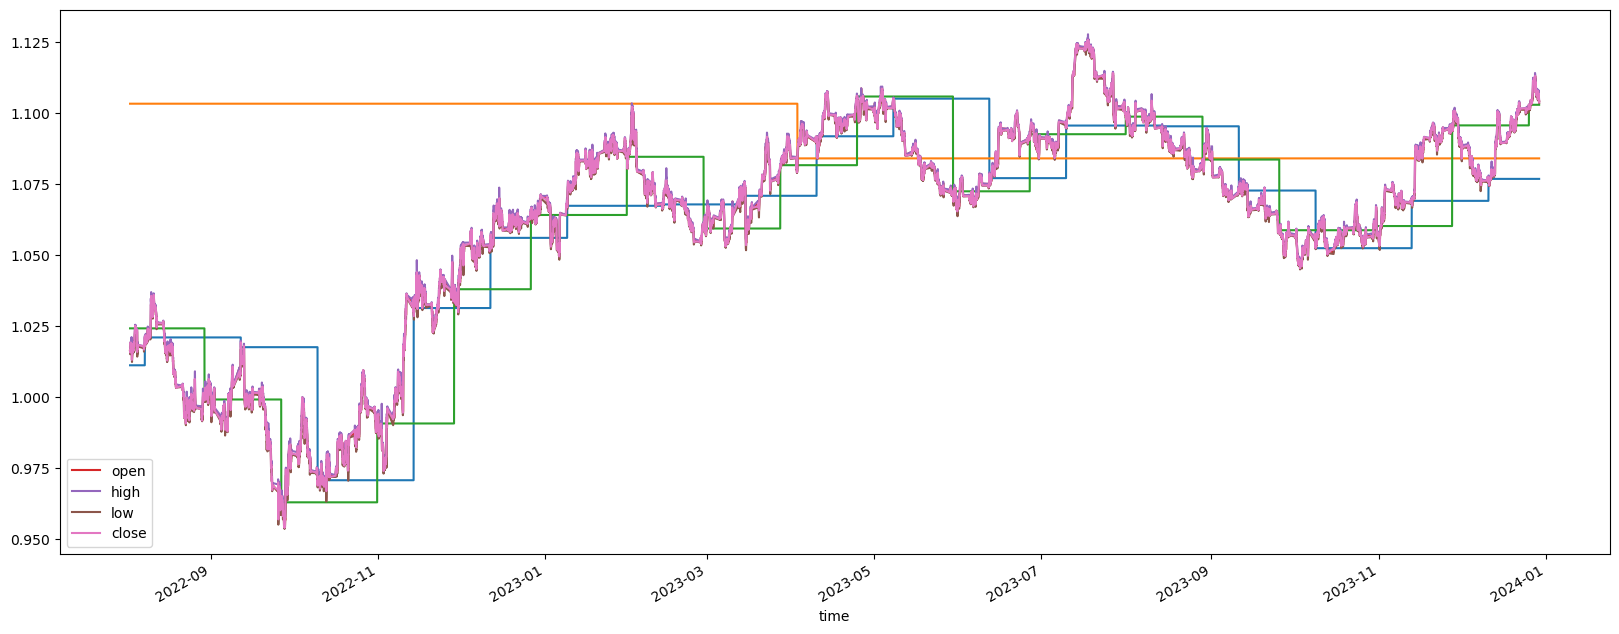

In [93]:
fig, ax = plt.subplots()

true_open_monthly.tail(8000).plot(figsize=(20, 8), ax=ax)
true_open_yearly.tail(8000).plot(figsize=(20, 8), ax=ax)
true_open_weekly.tail(8000).plot(figsize=(20, 8), ax=ax)

ohlc.tail(8000).plot(figsize=(20, 8), ax=ax)

plt.show()

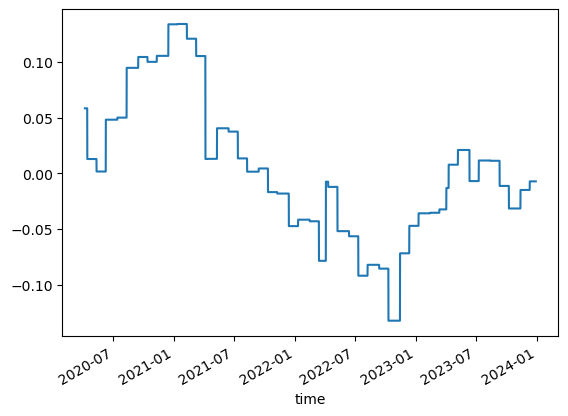

In [267]:
crossed_diff_monthly_yearly.plot()
plt.show()

In [95]:
trend_weekly = ohlc.close > ohlc.open.rolling(24*5*5).median()
trend_daily = ohlc.close > ohlc.open.rolling(24*5).median()
trend_hourly = ohlc.close > ohlc.open.rolling(50).median()
trend_entry = ohlc.close > ohlc.open.rolling(12).median()

# Weekly Trend (5 weeks of trading days, assuming 24 hours * 60 mins * 5 days * 5 weeks)
trend_weekly_diff = ohlc['close'] - ohlc['open'].rolling(window=24*5*5).median()
trend_daily_diff = ohlc['close'] - ohlc['open'].rolling(window=24*5).median()
trend_hourly_diff = ohlc['close'] - ohlc['open'].rolling(window=50).median()
trend_entry_diff = ohlc['close'] - ohlc['open'].rolling(window=12).median()

# Difference from the 'true open' reference
above_true_open_monthly_diff = ohlc['close'] - true_open_monthly
above_true_open_yearly_diff = ohlc['close'] - true_open_yearly
above_true_open_weekly_diff = ohlc['close'] - true_open_weekly

# Compute differences between various true open prices
crossed_diff_monthly_yearly = true_open_monthly - true_open_yearly
crossed_diff_monthly_weekly = true_open_monthly - true_open_weekly
crossed_diff_yearly_weekly = true_open_yearly - true_open_weekly

In [97]:
 def find_levels(
        price: np.array, atr: float, # Log closing price, and log atr
        first_w: float = 0.1,
        atr_mult: float = 3.0,
        prom_thresh: float = 0.1
):

    # Setup weights
    last_w = 1.0
    w_step = (last_w - first_w) / len(price)
    weights = first_w + np.arange(len(price)) * w_step
    weights[weights < 0] = 0.0

    # Get kernel of price.
    kernal = scipy.stats.gaussian_kde(price, bw_method=atr*atr_mult, weights=weights)

    # Construct market profile
    min_v = np.min(price)
    max_v = np.max(price)
    step = (max_v - min_v) / 200
    price_range = np.arange(min_v, max_v, step)
    pdf = kernal(price_range) # Market profile

    # Find significant peaks in the market profile
    pdf_max = np.max(pdf)
    prom_min = pdf_max * prom_thresh

    peaks, props = scipy.signal.find_peaks(pdf, prominence=prom_min)
    levels = []
    for peak in peaks:
        levels.append(np.exp(price_range[peak]))

    return levels, peaks, props, price_range, pdf, weights

def support_resistance_levels(
        data: pd.DataFrame,
        lookback: int,
        first_w: float = 0.01,
        atr_mult:float=3.0,
        prom_thresh:float =0.25
):

    # Get log average true range, 
    atr = ta.atr(np.log(data['high']), np.log(data['low']), np.log(data['close']), lookback)

    all_levels = [None] * len(data)
    for i in tqdm(range(lookback, len(data))):
        i_start  = i - lookback
        vals = np.log(data.iloc[i_start+1: i+1]['close'].to_numpy())
        levels, peaks, props, price_range, pdf, weights= find_levels(vals, atr.iloc[i], first_w, atr_mult, prom_thresh)
        all_levels[i] = levels
        
    return all_levels
#
support_resistances = support_resistance_levels(ohlc, 60*24*22*3)

NameError: name 'ta' is not defined

In [98]:
# Concatenate with existing indicators
indicators = pd.concat([
    above_true_open_monthly_diff,
    above_true_open_yearly_diff,
    above_true_open_weekly_diff,  # Difference from the true open
    crossed_diff_monthly_yearly,  # Monthly - Yearly Open
    crossed_diff_monthly_weekly,  # Monthly - Weekly Open
    crossed_diff_yearly_weekly,   # Yearly - Weekly Open
    trend_weekly_diff,            # Weekly trend difference
    trend_daily_diff,             # Daily trend difference
    trend_hourly_diff,            # Hourly trend difference
    trend_entry_diff              # Entry trend difference
], axis=1)

# Rename the columns to keep the original naming convention
indicators.columns = [
    "above_true_open_monthly_diff",
    "above_true_open_yearly_diff",
    "above_true_open_weekly_diff",
    "crossed_diff_monthly_yearly",
    "crossed_diff_monthly_weekly",
    "crossed_diff_yearly_weekly",
    "bullish_weekly",
    "bullish_daily",
    "bullish_hourly",
    "bullish_entry"
]

nan_summary(indicators)


,Missing Count,Missing Percentage
above_true_open_monthly_diff,180,0.746981
above_true_open_yearly_diff,1618,6.714529
above_true_open_weekly_diff,438,1.817654
crossed_diff_monthly_yearly,1618,6.714529
crossed_diff_monthly_weekly,438,1.817654
crossed_diff_yearly_weekly,1618,6.714529
bullish_weekly,599,2.485787
bullish_daily,119,0.493837
bullish_hourly,49,0.203345
bullish_entry,11,0.045649


In [220]:
import numba as nb

@nb.njit()
def log_return_nb(x):
    return np.log(x[-1]/x[0])

next_returns = ohlc.close.rolling(5).apply(log_return_nb, engine='numba', raw=True).shift(48*60)

In [221]:
up_next_returns = next_returns > 0

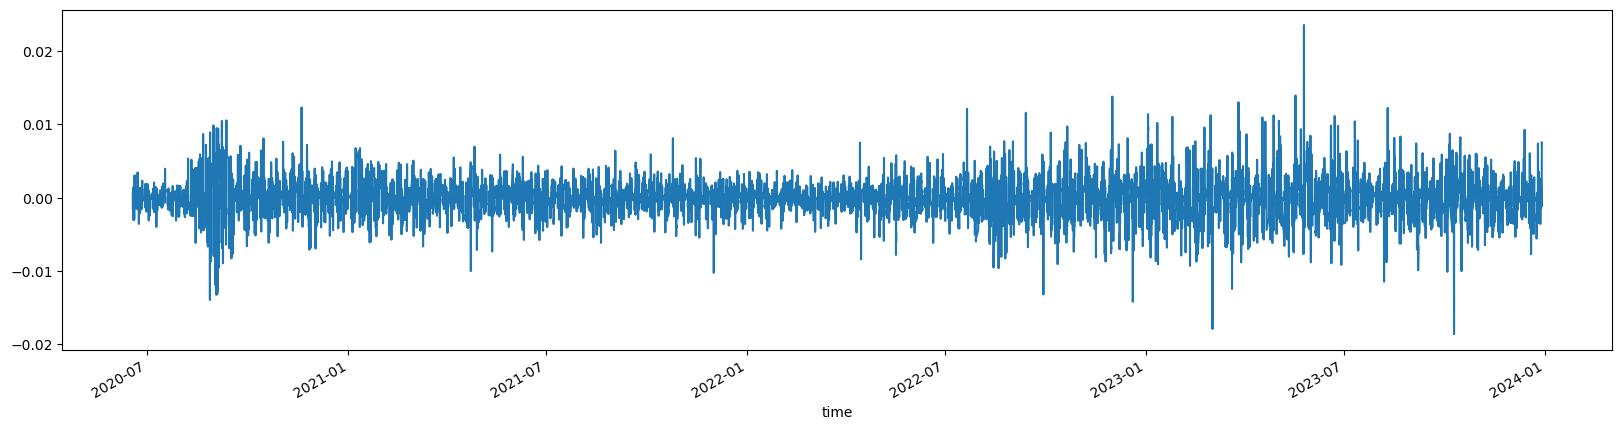

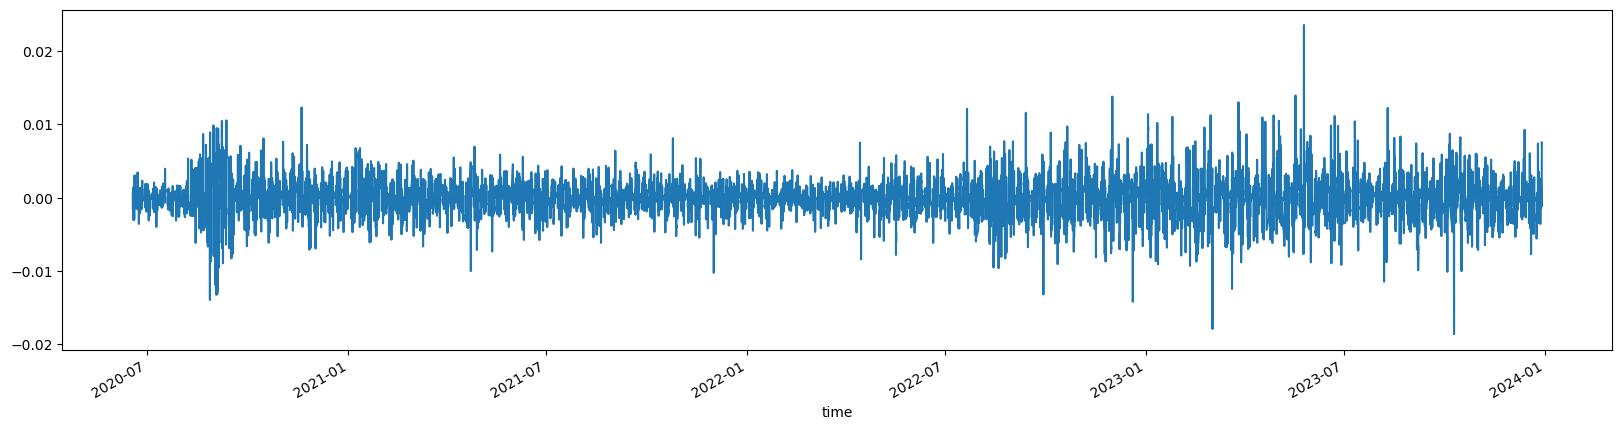

In [233]:
next_returns.plot(figsize=(20,5))
plt.show(())

In [234]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
import statsmodels.api as sm

X_train, X_test, y_train, y_test = train_test_split(indicators, up_next_returns, test_size=0.2, shuffle=False)

# OLS

In [255]:
# # Add a constant to the model (for the intercept)
# X_train = sm.add_constant(X_train)
#
# # Fit the OLS regression model
# model = sm.OLS(y_train, X_train).fit()
#
# # Predictions
# y_pred = model.predict(X_train)
#
# # Performance Metrics
# r_squared = model.rsquared
# adj_r_squared = model.rsquared_adj
# mse = mean_squared_error(y_train, y_pred)
# rmse = np.sqrt(mse)
#
# metrics = {
#     'R-squared': r_squared,
#     'Adjusted R-squared': adj_r_squared,
#     'MSE': mse,
#     'RMSE': rmse
# }
#
# # Display the regression summary
# print(model.summary())

# Logit

In [236]:
# # Add a constant to the model (for the intercept)
# X_train = sm.add_constant(X_train)
#
# # Fit the OLS regression model
# model = sm.Logit(y_train, X_train).fit()
#
# # Predictions
# y_pred = model.predict(X_train)
#
# # Performance Metrics
# r_squared = model.prsquared
# mse = mean_squared_error(y_train, y_pred)
# rmse = np.sqrt(mse)
#
# metrics = {
#     'R-squared': r_squared,
#     'MSE': mse,
#     'RMSE': rmse
# }
#
# # Display the regression summary
# print(model.summary())

# Catboost

In [257]:
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error, log_loss

def catboost_classification_with_metrics(X_train, y_train):
    """
    Fits a CatBoostClassifier, makes predictions, and computes performance metrics.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Binary target variable.

    Returns:
        model (CatBoostClassifier): Trained CatBoost model.
        metrics (dict): Dictionary containing Pseudo R-squared, MSE, and RMSE.
    """
    # Initialize CatBoost Classifier
    model = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=4,
        verbose=0,  # Suppress output
        loss_function='Logloss'  # Equivalent to logistic regression
    )

    # Fit the model
    model.fit(X_train, y_train)

    # Predictions (probabilities)
    y_pred_proba = model.predict_proba(X_train)[:, 1]  # Probability of class 1

    # Performance Metrics
    # 1. Pseudo R-squared (similar to Logit model's prsquared)
    ll_full = -log_loss(y_train, y_pred_proba, normalize=False)
    ll_null = -log_loss(y_train, np.full_like(y_train, y_train.mean()), normalize=False)
    pseudo_r_squared = 1 - (ll_full / ll_null)

    # 2. Mean Squared Error (MSE)
    mse = mean_squared_error(y_train, y_pred_proba)

    # 3. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Metrics dictionary
    metrics = {
        'Pseudo R-squared': pseudo_r_squared,
        'MSE': mse,
        'RMSE': rmse
    }

    # Display Model Summary (feature importance)
    print("Feature Importance:")
    feature_importance = pd.Series(model.get_feature_importance(), index=X_train.columns)
    print(feature_importance.sort_values(ascending=False))

    return model, metrics


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [238]:
model, performance_metrics = catboost_classification_with_metrics(X_train, y_train)

NameError: name 'catboost_classification_with_metrics' is not defined

# Decision tree

In [239]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error, log_loss

def decision_tree_classification_with_metrics(X_train, y_train, max_depth=4):
    """
    Fits a DecisionTreeClassifier, makes predictions, computes performance metrics,
    and visualizes the decision tree.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Binary target variable.
        max_depth (int): Maximum depth of the tree.

    Returns:
        model (DecisionTreeClassifier): Trained Decision Tree model.
        metrics (dict): Dictionary containing Pseudo R-squared, MSE, and RMSE.
    """
    # Initialize Decision Tree Classifier
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)

    # Fit the model
    model.fit(X_train, y_train)

    # Predictions (probabilities)
    print(model.predict_proba(X_train))
    y_pred_proba = model.predict_proba(X_train)[:, 1]  # Probability of class 1

    # Performance Metrics
    # 1. Pseudo R-squared (similar to Logit model's prsquared)
    ll_full = -log_loss(y_train, y_pred_proba, normalize=False)
    ll_null = -log_loss(y_train, np.full_like(y_train, y_train.mean()), normalize=False)
    pseudo_r_squared = 1 - (ll_full / ll_null)

    # 2. Mean Squared Error (MSE)
    mse = mean_squared_error(y_train, y_pred_proba)

    # 3. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Metrics dictionary
    metrics = {
        'Pseudo R-squared': pseudo_r_squared,
        'MSE': mse,
        'RMSE': rmse
    }

    # Visualizing the Decision Tree
    plt.figure(figsize=(20, 12))  # Increase figure size
    plot_tree(model, feature_names=X_train.columns, class_names=['0', '1'], filled=True, rounded=True)
    plt.title("Decision Tree Visualization", fontsize=16)

    # Save as a high-resolution image
    plt.savefig("dec_tree_high_res.png", dpi=300, bbox_inches="tight")

    return model, metrics

[[1.        0.       ]
 [1.        0.       ]
 [1.        0.       ]
 ...
 [0.5732899 0.4267101]
 [0.5732899 0.4267101]
 [0.5732899 0.4267101]]


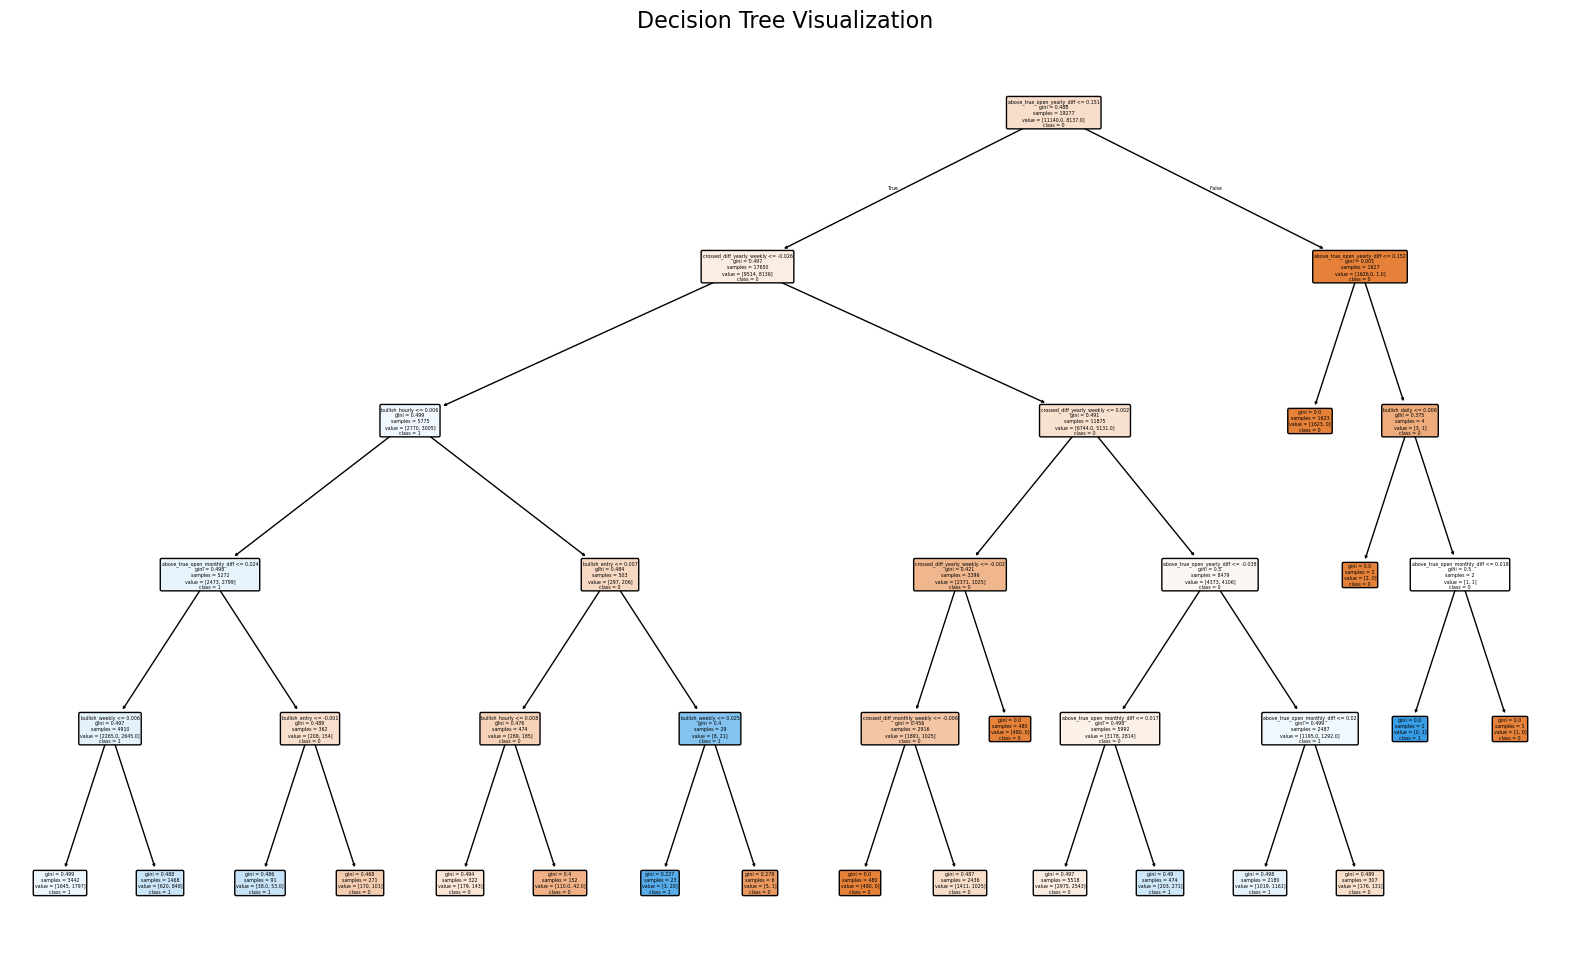

In [241]:
model, metrics = decision_tree_classification_with_metrics(X_train, y_train, max_depth=5)

In [242]:
# Random Forest

In [248]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, log_loss

def random_forest_classification_with_metrics(X_train, y_train, n_estimators=300, max_depth=6):
    """
    Fits a RandomForestClassifier, makes predictions, computes performance metrics,
    and visualizes one of the decision trees in the forest.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Binary target variable.
        n_estimators (int): Number of trees in the forest.
        max_depth (int): Maximum depth of the trees.

    Returns:
        model (RandomForestClassifier): Trained Random Forest model.
        metrics (dict): Dictionary containing Pseudo R-squared, MSE, and RMSE.
    """
    # Initialize Random Forest Classifier
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

    # Fit the model
    model.fit(X_train, y_train)

    # Predictions (probabilities)
    y_pred_proba = model.predict_proba(X_train)[:, 1]  # Probability of class 1

    # Performance Metrics
    # 1. Pseudo R-squared (similar to Logit model's prsquared)
    ll_full = -log_loss(y_train, y_pred_proba, normalize=False)
    ll_null = -log_loss(y_train, np.full_like(y_train, y_train.mean()), normalize=False)
    pseudo_r_squared = 1 - (ll_full / ll_null)

    # 2. Mean Squared Error (MSE)
    mse = mean_squared_error(y_train, y_pred_proba)

    # 3. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Metrics dictionary
    metrics = {
        'Pseudo R-squared': pseudo_r_squared,
        'MSE': mse,
        'RMSE': rmse
    }

    # Visualizing one of the Decision Trees in the Random Forest
    plt.figure(figsize=(20, 12))  # Increase figure size
    plot_tree(model.estimators_[0], feature_names=X_train.columns, class_names=['0', '1'], filled=True, rounded=True)
    plt.title("Random Forest Decision Tree Visualization", fontsize=16)

    # Save as a high-resolution image
    plt.savefig("random_forest_tree_high_res.png", dpi=300, bbox_inches="tight")

    return model, metrics


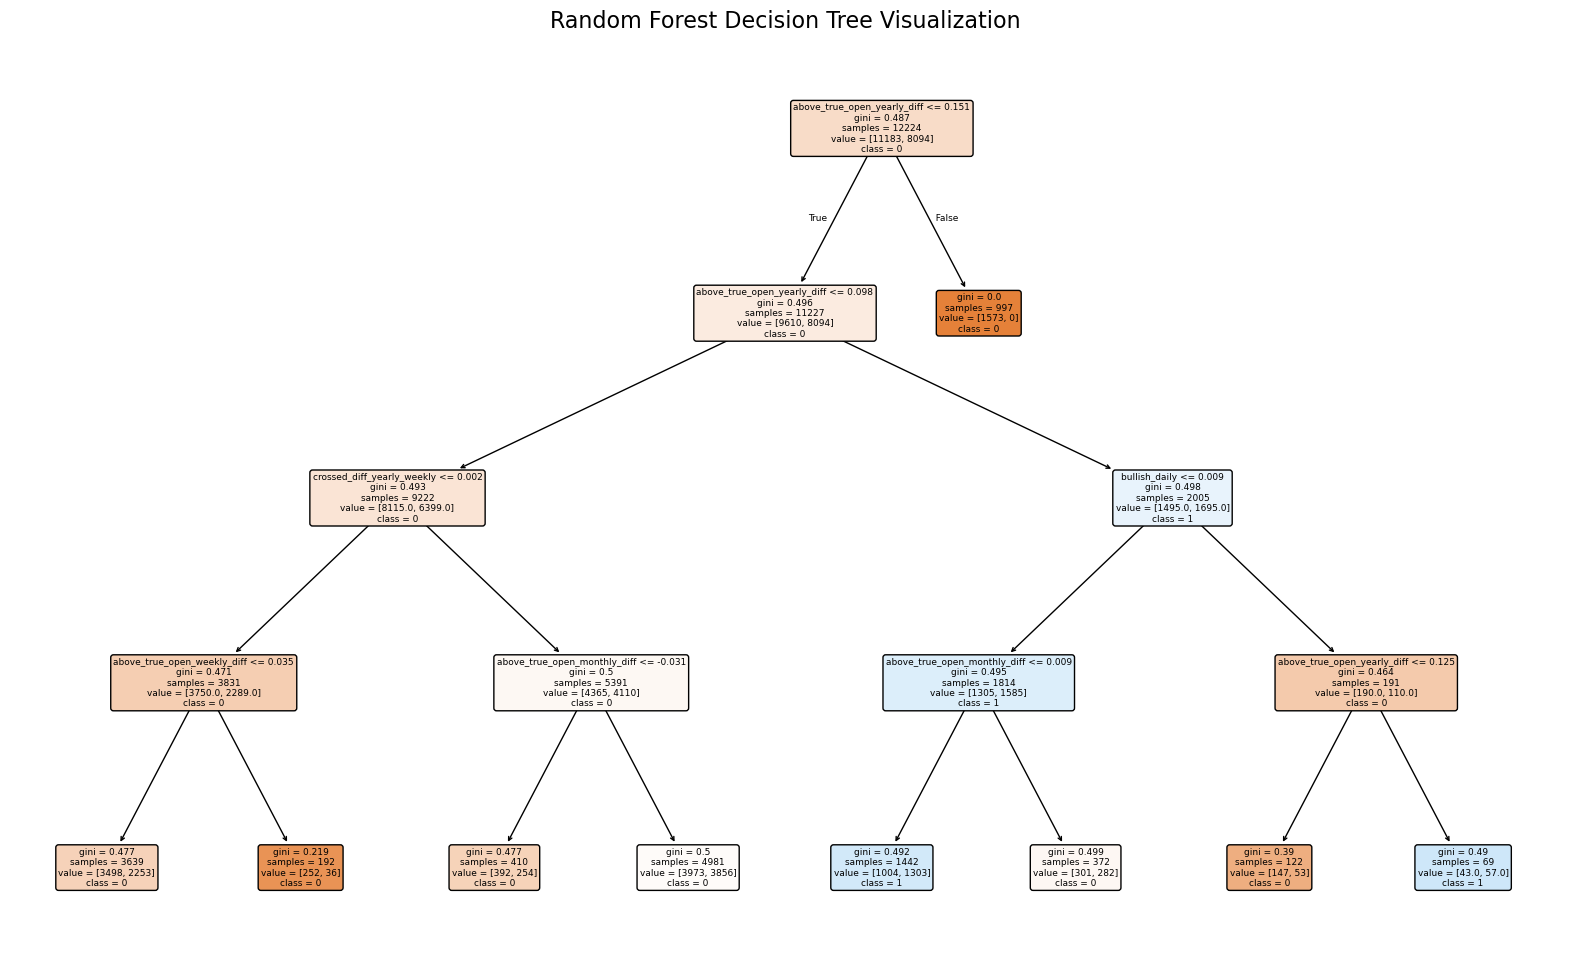

In [249]:
model, metrics = random_forest_classification_with_metrics(X_train, y_train, max_depth=4)

# SIgnal Generation

In [250]:
model.predict_proba(X_test)

array([[0.52481595, 0.47518405],
       [0.51876527, 0.48123473],
       [0.51971248, 0.48028752],
       ...,
       [0.60201002, 0.39798998],
       [0.60201002, 0.39798998],
       [0.60127787, 0.39872213]])

In [251]:
y_pred = pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)

In [252]:
conf_matrix = confusion_matrix(y_test, y_pred > 0.5)

In [253]:
pd.DataFrame( conf_matrix ).style.background_gradient(axis=None)

,0,1
0,2353,0
1,2467,0


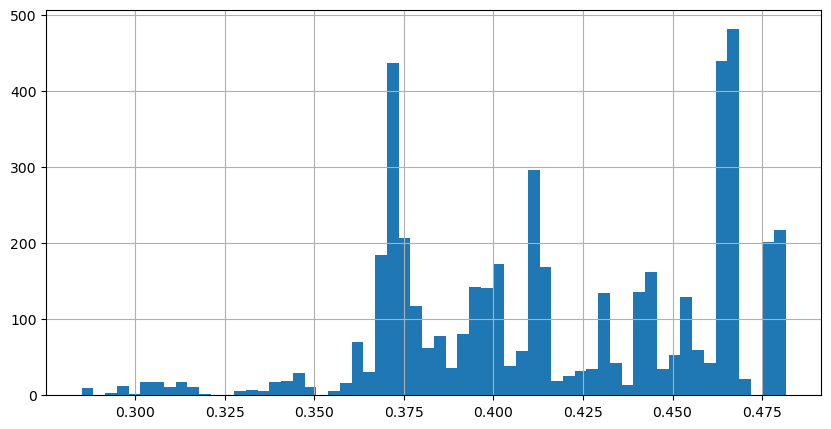

In [254]:
y_pred.hist(bins=60, figsize=(10, 5))
plt.show(

)

In [176]:
import vectorbt as vbt

In [193]:
def generate_signals(y_pred, threshold=0.2):
    """
    Generates long and short signals with corresponding exits 48 hours after the entry.

    Parameters:
        y_pred (pd.Series): Series representing probabilities of bullish signals (0 to 1).

    Returns:
        pd.DataFrame: DataFrame containing long_signals, long_exits, short_signals, short_exits.
    """
    # Entry signals
    if np.all(y_pred >= 0):
        print("Using probabilities..")
        long_signals = y_pred > 1-threshold
        short_signals = y_pred < threshold
    else:
        print("Using normalized probabilities..")
        long_signals = y_pred > threshold
        short_signals = y_pred < -threshold

    # Exit signals (48 hours after entry)
    # Assuming y_pred has datetime index with hourly frequency
    # long_exits = long_signals.shift(48, fill_value=False)
    # short_exits = short_signals.shift(48, fill_value=False)

    long_exits = y_pred.vbt.crossed_below(0.5)
    short_exits = y_pred.vbt.crossed_above(0.5)
    
    # Long exists (holding the long position after the signal)
    long_exists = long_signals.cumsum() - long_exits.cumsum() > 0

    # Create DataFrame for better visualization
    signals_df = pd.DataFrame({
        'long_signals': long_signals.astype(bool),
        'long_exists': long_exists.astype(bool),
        'long_exits': long_exits.astype(bool),
        'short_signals': short_signals.astype(bool),
        'short_exits': short_exits.astype(bool)
    }, index=y_pred.index)

    return signals_df


In [196]:
y_pred = pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)

y_pred_mean = y_pred.rolling(60*3).mean()
y_pred_std = (y_pred-y_pred_mean).rolling(60*3).std()
y_pred_norm = (y_pred - y_pred_mean)/(y_pred_std)

signals = generate_signals(y_pred_norm, 4)

Using normalized probabilities..


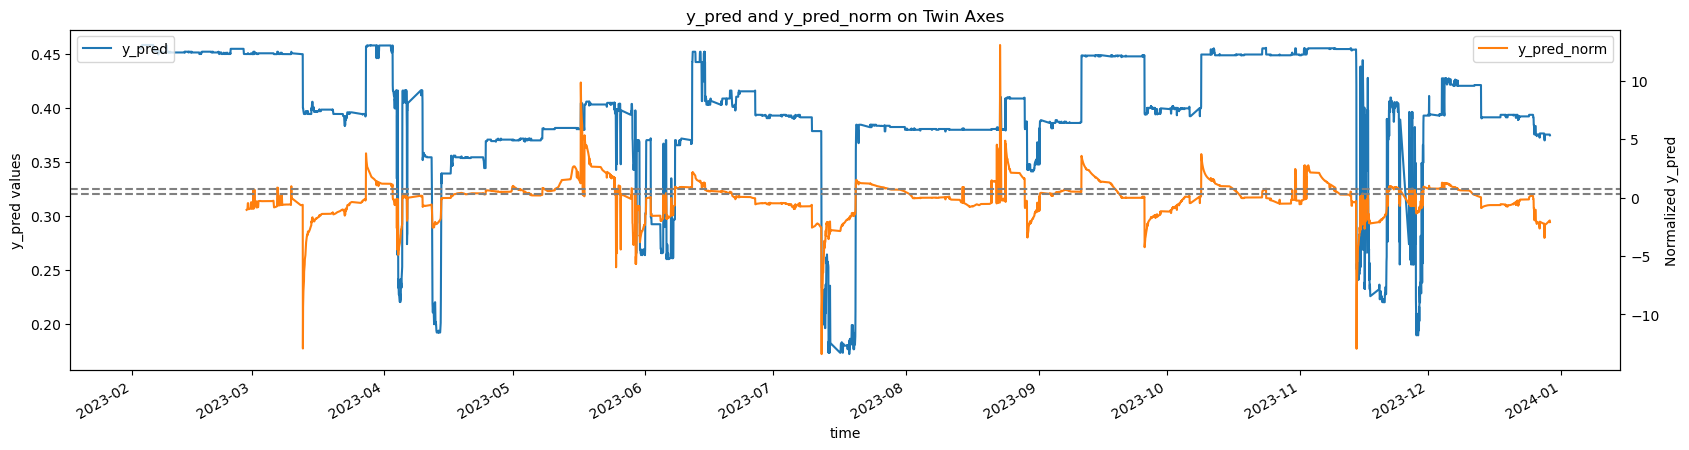

In [197]:
fig, ax1 = plt.subplots(figsize=(20,5))

# Plot the first time series on ax1
y_pred.tail(10000).plot(ax=ax1, label="y_pred", color="C0")
ax1.set_ylabel("y_pred values")  # Label for the left y-axis
ax1.legend(loc="upper left")

# Create the twin axis that shares the x-axis
ax2 = ax1.twinx()

# Plot the normalized values on the twin axis
y_pred_norm.tail(10000).plot(ax=ax2, label="y_pred_norm", color="C1")
ax2.set_ylabel("Normalized y_pred")  # Label for the right y-axis
ax2.legend(loc="upper right")

# Add the horizontal lines on the twin axis (because they correspond to y_pred_norm)
ax2.axhline(1 - 0.3, color="gray", linestyle="--")
ax2.axhline(0.3, color="gray", linestyle="--")

plt.title("y_pred and y_pred_norm on Twin Axes")
plt.show()

In [198]:
common = signals.index.intersection(ohlc.index)

portfolio = vbt.Portfolio.from_signals(
    close=ohlc.close.loc[common],  # Use actual price series here
    entries=signals['long_signals'].loc[common].astype(int),
    exits=signals['long_exits'].loc[common].astype(int),
    init_cash=1000000,
    size=1,
    short_entries=signals['short_signals'].loc[common].astype(int),
    short_exits=signals['short_exits'].loc[common].astype(int),
    freq="1m",
    accumulate=False,
)

In [199]:
portfolio.stats()

Start                         2023-02-03 02:00:00-05:00
End                           2023-12-29 11:00:00-05:00
Period                                  3 days 08:20:00
Start Value                                   1000000.0
End Value                                  999999.95771
Total Return [%]                              -0.000004
Benchmark Return [%]                           0.947633
Max Gross Exposure [%]                         0.000108
Total Fees Paid                                     0.0
Max Drawdown [%]                               0.000007
Max Drawdown Duration                   2 days 23:07:00
Total Trades                                         17
Total Closed Trades                                  17
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  47.058824
Best Trade [%]                                 0.362007
Worst Trade [%]                               -1

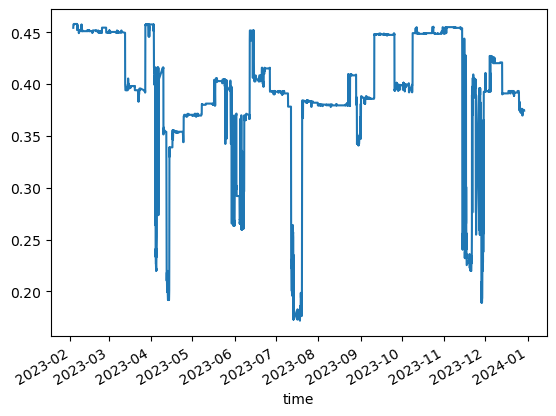

In [200]:
y_pred.plot()
plt.show()

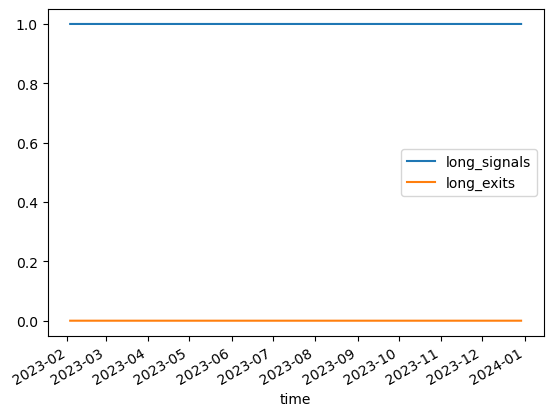

In [166]:
signals[["long_signals", "long_exits"]].astype(int).plot()
plt.show()

In [167]:
(signals["long_signals"] & signals["long_exits"]).sum()

np.int64(0)

In [ ]:
signals['long_signals'].loc[common].sum()

In [ ]:
portfolio.plot_position_pnl()

In [ ]:
portfolio.plot_trades()